In [134]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn import ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

In [60]:
titanic_train_data = pd.read_csv('../train.csv')
titanic_test_data = pd.read_csv('../test.csv')
titanic_data_cleaner = [titanic_train_data, titanic_test_data]
titanic_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [61]:
for sample_dataset in titanic_data_cleaner:   
    sample_dataset['Age'].fillna(sample_dataset['Age'].median(), inplace = True)
    sample_dataset['Embarked'].fillna(sample_dataset['Embarked'].mode()[0], inplace = True)
    sample_dataset['Fare'].fillna(sample_dataset['Fare'].median(), inplace = True)

In [62]:
titanic_train_data.drop(['PassengerId','Cabin', 'Ticket'],axis=1,inplace=True)
print(titanic_train_data.isnull().sum())
print(titanic_test_data.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [63]:
titanic_test_data['Age'] = titanic_test_data['Age'].astype(int)
titanic_train_data['Age'] = titanic_train_data['Age'].astype(int)

In [64]:
titanic_test_data['Family'] =  titanic_test_data["Parch"] + titanic_test_data["SibSp"]
titanic_test_data['Family'].loc[titanic_test_data['Family'] > 0] = 1
titanic_test_data['Family'].loc[titanic_test_data['Family'] == 0] = 0
titanic_test_data = titanic_test_data.drop(['SibSp','Parch'], axis=1)


C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [65]:
titanic_train_data['Family'] =  titanic_train_data["Parch"] + titanic_train_data["SibSp"]
titanic_train_data['Family'].loc[titanic_train_data['Family'] > 0] = 1
titanic_train_data['Family'].loc[titanic_train_data['Family'] == 0] = 0
titanic_train_data = titanic_train_data.drop(['SibSp','Parch'], axis=1)

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [66]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
titanic_train_data['Person'] = titanic_train_data[['Age','Sex']].apply(get_person,axis=1)
titanic_test_data['Person']  = titanic_test_data[['Age','Sex']].apply(get_person,axis=1)
titanic_test_data.drop(['Sex'],axis=1,inplace=True)
titanic_train_data.drop(['Sex'],axis=1,inplace=True)

In [67]:
person_dummies_titanic  = pd.get_dummies(titanic_train_data['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(titanic_test_data['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_train_data = titanic_train_data.join(person_dummies_titanic)
titanic_test_data  = titanic_test_data.join(person_dummies_test)

titanic_test_data.drop(['Person'],axis=1,inplace=True)
titanic_train_data.drop(['Person'],axis=1,inplace=True)

In [68]:
titanic_train_data["Embarked"] = titanic_train_data["Embarked"].fillna("S")
embark_perc = titanic_train_data[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
embark_dummies_titanic  = pd.get_dummies(titanic_train_data['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(titanic_test_data['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_train_data = titanic_train_data.join(embark_dummies_titanic)
titanic_test_data = titanic_test_data.join(embark_dummies_test)

titanic_train_data.drop(['Embarked'], axis=1,inplace=True)
titanic_test_data.drop(['Embarked'], axis=1,inplace=True)

In [70]:
titanic_train_data = titanic_train_data.drop(['Name'], axis=1)
titanic_test_data = titanic_test_data.drop(['Name','Cabin','Ticket'], axis=1)

In [71]:
X_train = titanic_train_data.drop("Survived",axis=1)
Y_train = titanic_train_data["Survived"]
X_test  = titanic_test_data.drop("PassengerId", axis=1).copy()
#Y_test = titanic_test_data["Survived"]

In [72]:
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.9797979797979798

In [76]:
%%time
hyper_param = { 
                'n_estimators' : [500,1200],
                'max_depth': range(1,5,2),
                'max_features': ('log2', 'sqrt'),
                'class_weight':[{1: w} for w in [1, 1.5]]
              }

grid_rf = GridSearchCV(RandomForestClassifier(random_state=15), hyper_param)

grid_rf.fit(X_train, Y_train)
print("\nBest parameters \n" + str(grid_rf.best_params_))

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



Best parameters 
{'class_weight': {1: 1}, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 1200}
Wall time: 53.2 s


In [83]:
X_train_temp,X_test_temp,Y_train_temp,Y_test_temp = train_test_split(X_train,Y_train,test_size=0.40)
XGBoosting_model = xgb.XGBClassifier()
XGBoosting_model.fit(X_train_temp, Y_train_temp)
Y_predict = XGBoosting_model.predict(X_test_temp)
print("%s" % XGBoosting_model.score(X_test_temp, Y_test_temp))

0.8067226890756303


Accuracy: 80.67%


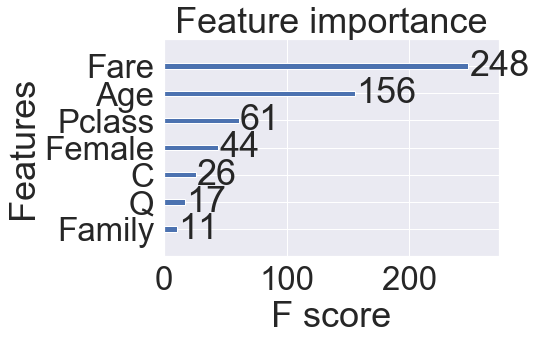

In [98]:
predictions = [round(value) for value in Y_predict]

# Find Accuracy
accuracy = accuracy_score(Y_test_temp, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Display feature importance
plot_importance(XGBoosting_model)

In [86]:
logistic_model = LogisticRegression()

logistic_model.fit(X_train, Y_train)

Y_pred = logistic_model.predict(X_test)

logistic_model.score(X_train, Y_train)

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8069584736251403

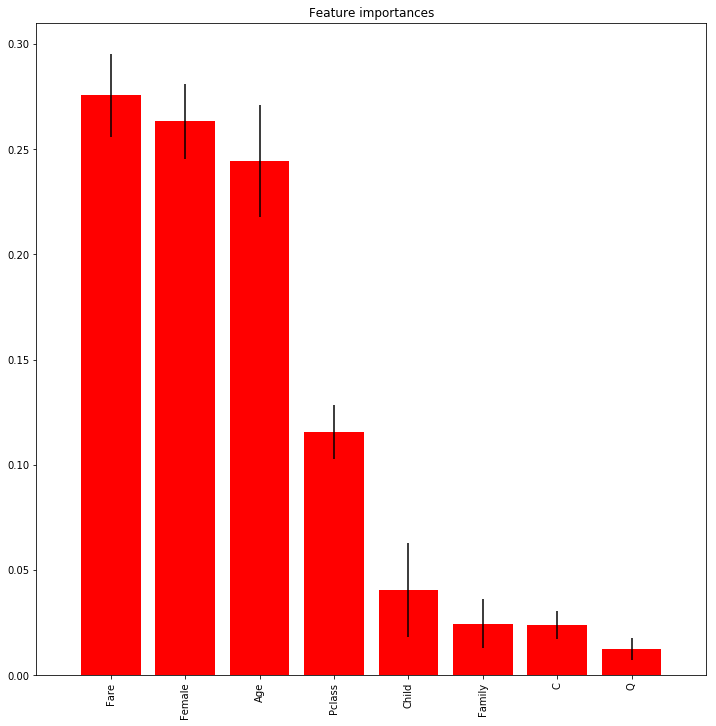

In [93]:
feat_names = X_train.columns
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(X_train, Y_train)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

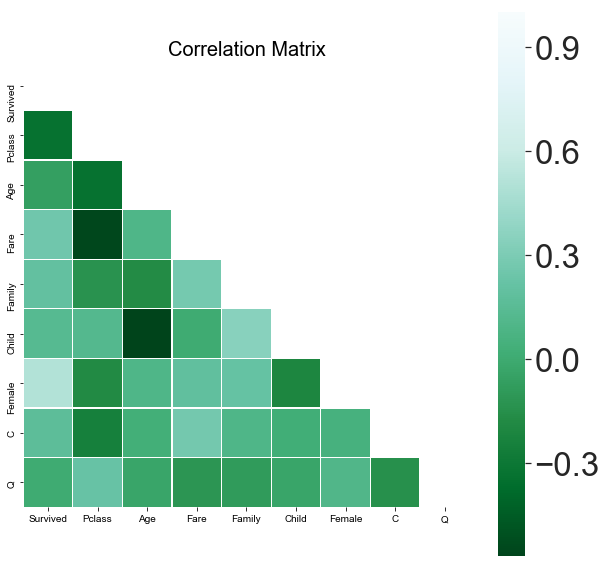

In [95]:
mask = np.zeros_like(titanic_train_data.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(10,10))
plt.title('Correlation Matrix',fontsize=20)
sns.set(font_scale=3)
sns.heatmap(titanic_train_data.corr(),linewidths=0.25,vmax=1.0,square=True,cmap="BuGn_r",mask=mask,linecolor='w',cbar={"shrink":.75})

To compare the RandomForest algorithm and Tree based boosting algorithm for regression problem, We have to use another dataset which I have used for assignment 3.

In [100]:
google_app_data = pd.read_csv(r'''C:\Users\Akshay\Desktop\MIS\First_Sem\Data_Sci_Eng_Mthd\Assignment3\googleplaystore.csv''',encoding="ISO-8859-1")
google_app_user_review = pd.read_csv(r'''C:\Users\Akshay\Desktop\MIS\First_Sem\Data_Sci_Eng_Mthd\Assignment3\googleplaystore_user_reviews.csv''',encoding="ISO-8859-1")

In [101]:
google_app_data.drop(google_app_data.loc[google_app_data['Type'] == "0"].index, inplace=True, axis=0)
google_app_data.drop(google_app_data.loc[google_app_data['Installs'] == "0"].index, axis=0, inplace=True)
google_app_data.drop(google_app_data.loc[google_app_data['Rating'].isna()].index, axis=0, inplace=True)
google_app_data.drop(google_app_data.loc[google_app_data['Size'] == "Varies with device"].index, axis=0, inplace=True)

google_app_data['Size'] = google_app_data['Size'].apply(lambda x:float(x.replace("M", ""))*1024 if "M" in x else float(x.replace("k","")))
google_app_data['Reviews'] = google_app_data['Reviews'].astype(float)
google_app_data.reset_index(drop=True, inplace=True)

values = {'Rating': 0.0, 'Type': 'Free', 'Content Rating': 'Unrated','Price':'0.0'}
google_app_data.fillna(value=values, inplace=True)
google_app_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7729 entries, 0 to 7728
Data columns (total 13 columns):
App               7729 non-null object
Category          7729 non-null object
Rating            7729 non-null float64
Reviews           7729 non-null float64
Size              7729 non-null float64
Installs          7729 non-null object
Type              7729 non-null object
Price             7729 non-null object
Content Rating    7729 non-null object
Genres            7729 non-null object
Last Updated      7729 non-null object
Current Ver       7725 non-null object
Android Ver       7727 non-null object
dtypes: float64(3), object(10)
memory usage: 785.1+ KB


In [102]:
def price_quality(temp):
    if temp == "0":
        return 0
    else:
        temp = temp[1:]
        temp = float(temp)
        return temp
    
    
google_app_data['Price'] = google_app_data['Price'].map(price_quality).astype(float)  
google_app_data.drop_duplicates(subset='App', keep='first', inplace=True)

In [103]:
google_app_data.drop(columns=['App', 'Last Updated', 'Current Ver', 'Android Ver','Installs'], axis=1, inplace=True)
google_app_data_with_categories = pd.DataFrame(pd.get_dummies(google_app_data))
google_app_data_with_categories.info()
google_app_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7029 entries, 0 to 7728
Columns: 156 entries, Rating to Genres_Word
dtypes: float64(4), uint8(152)
memory usage: 1.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7029 entries, 0 to 7728
Data columns (total 8 columns):
Category          7029 non-null object
Rating            7029 non-null float64
Reviews           7029 non-null float64
Size              7029 non-null float64
Type              7029 non-null object
Price             7029 non-null float64
Content Rating    7029 non-null object
Genres            7029 non-null object
dtypes: float64(4), object(4)
memory usage: 494.2+ KB


In [115]:
columns_drop = ['Rating', 'Category', 'Genres']
model_data = google_app_data.drop(columns=columns_drop)
model_data = pd.DataFrame(pd.get_dummies(model_data))
#model_data.info()
Y1 = google_app_data.Rating

x1_train, x1_test, y1_train, y1_test = train_test_split(model_data, Y1, test_size=0.3)
random_forest_reg = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
random_forest_reg.fit(x1_train, y1_train)

print(random_forest_reg.feature_importances_)
print(random_forest_reg.predict(x1_test))
print(random_forest_reg.score(x1_test, y1_test))

[9.61761607e-01 1.15842665e-02 1.62795048e-02 4.38050442e-03
 5.36913970e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.24977935e-04 0.00000000e+00]
[4.05053556 4.04893614 4.24197566 ... 4.04893614 4.04893614 4.05251929]
0.038102236842112


In [116]:
%%time
param_grid = { 
            "n_estimators"      : [10,20,30,50,100,200],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,6,8,10],
            "bootstrap": [True, False],
            }

grid_rf = GridSearchCV(random_forest_reg, param_grid, n_jobs=-1, cv=5)

grid_rf.fit(x1_train, y1_train)
print("\nBest parameters \n" + str(grid_rf.best_params_))
print("\nBest Score",grid_rf.best_score_)


Best parameters 
{'bootstrap': True, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 50}

Best Score 0.042099448041996994
Wall time: 1min 25s


In [128]:
ada_regr=AdaBoostRegressor(learning_rate=1, n_estimators=500)
ada_regr.fit(x1_train,y1_train)
print(ada_regr.score(x1_test, y1_test))

-0.07461470861351382


In [130]:
parameters = {'n_estimators': (1, 2),'base_estimator__max_depth': (1, 2)}
clf = GridSearchCV(ada_regr, parameters)
clf.fit(x1_train,y1_train)
print("\nBest parameters \n" + str(clf.best_params_))
print("\nBest Score",clf.best_score_)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7029 entries, 0 to 7728
Data columns (total 8 columns):
Category          7029 non-null object
Rating            7029 non-null float64
Reviews           7029 non-null float64
Size              7029 non-null float64
Type              7029 non-null object
Price             7029 non-null float64
Content Rating    7029 non-null object
Genres            7029 non-null object
dtypes: float64(4), object(4)
memory usage: 494.2+ KB


In [137]:
model_data = google_app_data.drop(columns=['Rating','Category', 'Genres', 'Content Rating', 'Type', 'Reviews'])
Y1 = google_app_data.Rating
x1_train, x1_test, y1_train, y1_test = train_test_split(model_data, Y1, test_size=0.3)

linear_model = LinearRegression()
linear_model.fit(x1_train, y1_train)
result = linear_model.predict(x1_test)

model1_ols = sm.OLS(Y1, model_data[model_data.columns])
model1_metrics = model1_ols.fit()
print(model1_metrics.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     3240.
Date:                Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                        06:52:00   Log-Likelihood:                -17761.
No. Observations:                7029   AIC:                         3.553e+04
Df Residuals:                    7027   BIC:                         3.554e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Size        8.996e-05   1.12e-06     80.192      0.0

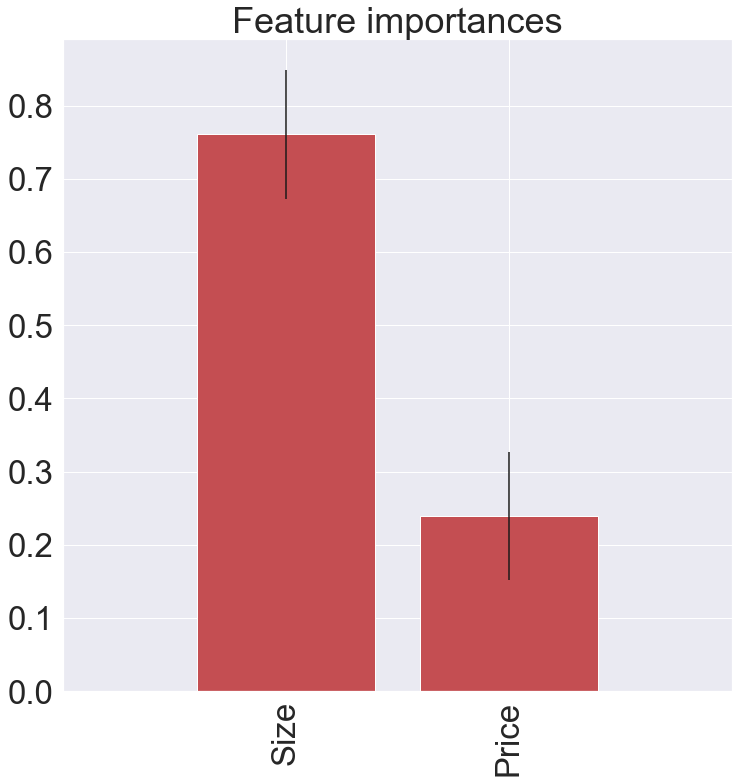

In [139]:
feat_names = x1_train.columns
model2 = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model2.fit(x1_train, y1_train)

## plot the importances ##
importances = model2.feature_importances_
std = np.std([tree.feature_importances_ for tree in model2.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

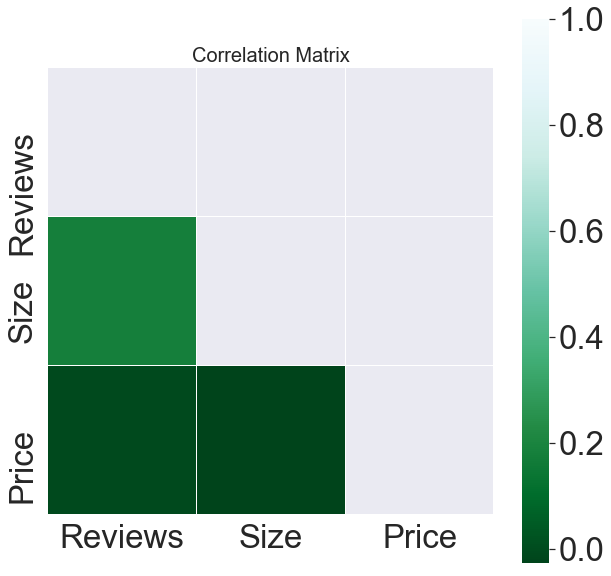

In [138]:
full_data = google_app_data.drop(columns=['Rating','Category', 'Genres', 'Content Rating','Type'])
mask = np.zeros_like(full_data.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(10,10))
plt.title('Correlation Matrix',fontsize=20)
sns.set(font_scale=3)
sns.heatmap(full_data.corr(),linewidths=0.25,vmax=1.0,square=True,cmap="BuGn_r",mask=mask,linecolor='w',cbar={"shrink":.75})